# RQ2 - Structural, Linguistic Analysis

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [35]:
df = pd.read_csv('../conversation_analysis/results/results_conversations_with_annotation.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,chat_id,github_link,gpt_link,system_prompt,prompts,answers,state,state_reason,...,total_text_speak,ARI,Coleman_Liau,Flesch_reading_ease,Flesch_Kincaid_grade,Gunning_Fog,Smog,total_sent,total_word_count,Did ChatGPT help with the issue
0,0,0,1,https://github.com/akorb/SteamShutdown/issues/52,https://chat.openai.com/share/d92cccd8-b7bb-4d...,[''],"[""Write me a bash script In the mean time, do ...","['Sure, here\'s a bash script that checks if t...",open,NaN,...,0,4.6,4.52,99.57,2.9,7.03,0.0,2,29,No
1,1,1,1,https://github.com/akorb/SteamShutdown/issues/52,https://chat.openai.com/share/d92cccd8-b7bb-4d...,[''],"[""Write me a bash script In the mean time, do ...","['Sure, here\'s a bash script that checks if t...",open,NaN,...,0,11.8,11.31,61.87,9.1,12.06,13.0,4,91,No
2,2,2,2,https://github.com/jeroen/resttesttest/issues/26,https://chat.openai.com/share/bf6d3826-0362-44...,"['', 'Original custom instructions no longer a...",['How do I add a body to a http post payload o...,['To add a body to an HTTP POST payload on [re...,open,NaN,...,0,3.6,3.12,82.44,5.3,7.09,8.3,7,87,No
3,3,3,2,https://github.com/jeroen/resttesttest/issues/26,https://chat.openai.com/share/bf6d3826-0362-44...,"['', 'Original custom instructions no longer a...",['How do I add a body to a http post payload o...,['To add a body to an HTTP POST payload on [re...,open,NaN,...,0,10.8,11.02,63.70,8.4,9.84,11.6,18,407,No
4,4,4,3,https://github.com/keycloakify/keycloakify/iss...,https://chat.openai.com/share/a3254182-6228-43...,"['', 'Original custom instructions no longer a...","[""In keycloak, is it possible to disable the p...","['In Keycloak, as of my last update, you can c...",closed,completed,...,0,8.7,9.21,64.71,8.0,10.00,0.0,2,31,Yes


### developers

In [5]:
df_prompts = df[df['ColumnID'] == 'prompts_fulltext_clean']
df_prompts.head()

,Unnamed: 0.1,Unnamed: 0,chat_id,github_link,gpt_link,system_prompt,prompts,answers,state,state_reason,...,total_text_speak,ARI,Coleman_Liau,Flesch_reading_ease,Flesch_Kincaid_grade,Gunning_Fog,Smog,total_sent,total_word_count,Did ChatGPT help with the issue
0,0,0,1,https://github.com/akorb/SteamShutdown/issues/52,https://chat.openai.com/share/d92cccd8-b7bb-4d...,[''],"[""Write me a bash script In the mean time, do ...","['Sure, here\'s a bash script that checks if t...",open,NaN,...,0,4.6,4.52,99.57,2.9,7.03,0.0,2,29,No
2,2,2,2,https://github.com/jeroen/resttesttest/issues/26,https://chat.openai.com/share/bf6d3826-0362-44...,"['', 'Original custom instructions no longer a...",['How do I add a body to a http post payload o...,['To add a body to an HTTP POST payload on [re...,open,NaN,...,0,3.6,3.12,82.44,5.3,7.09,8.3,7,87,No
4,4,4,3,https://github.com/keycloakify/keycloakify/iss...,https://chat.openai.com/share/a3254182-6228-43...,"['', 'Original custom instructions no longer a...","[""In keycloak, is it possible to disable the p...","['In Keycloak, as of my last update, you can c...",closed,completed,...,0,8.7,9.21,64.71,8.0,10.00,0.0,2,31,Yes
6,6,6,4,https://github.com/netdisco/snmp-info/issues/480,https://chat.openai.com/share/d8686d8d-1ebe-4e...,[''],['I am trying to set up Netdisco on an Amazon ...,['\n\nIf your Netdisco installation is using t...,closed,completed,...,0,6.9,7.64,76.52,5.5,5.93,9.4,112,1429,Yes
8,8,12,7,https://github.com/juliuscc/semantic-release-s...,https://chat.openai.com/share/e75da555-669f-42...,[''],"['Hello, need help with semantic-release npm p...",['Integrating a Slack bot with the `semantic-r...,open,NaN,...,0,12.8,7.49,60.99,11.5,13.76,0.0,1,28,No


In [6]:
categories = [
    "WC", "Analytic", "Clout", "Authentic", "Tone", "WPS", "BigWords", "Dic", "Linguistic", "function", "pronoun",
    "ppron", "i", "we", "you", "shehe", "they", "ipron", "det", "article", "number", "prep", "auxverb", "adverb",
    "conj", "negate", "verb", "adj", "quantity", "Drives", "affiliation", "achieve", "power", "Cognition", "allnone",
    "cogproc", "insight", "cause", "discrep", "tentat", "certitude", "differ", "memory", "Affect", "tone_pos", 
    "tone_neg", "emotion", "emo_pos", "emo_neg", "emo_anx", "emo_anger", "emo_sad", "swear", "Social", "socbehav", 
    "prosocial", "polite", "conflict", "moral", "comm", "socrefs", "family", "friend", "female", "male", "Culture", 
    "politic", "ethnicity", "tech", "Lifestyle", "leisure", "home", "work", "money", "relig", "Physical", "health", 
    "illness", "wellness", "mental", "substances", "sexual", "food", "death", "need", "want", "acquire", "lack", 
    "fulfill", "fatigue", "reward", "risk", "curiosity", "allure", "Perception", "attention", "motion", "space", 
    "visual", "auditory", "feeling", "time", "focuspast", "focuspresent", "focusfuture", "Conversation", "netspeak", 
    "assent", "nonflu", "filler", "AllPunc", "Period", "Comma", "QMark", "Exclam", "Apostro", "OtherP", "Emoji", 
    "num_prim_quest", "num_prim_ks_ques", "num_acc_ans", "num_urls", "num_code_snippets", "mean_size_code_snippets", 
    "num_api_calls_text", "num_api_calls_code", "code_descs", "se_words", "err_msgs", "distinct_words", "uniq_info", 
    "misspelled", "incomplete_count", "complete_count", "total_text_speak", "ARI", "Coleman_Liau", "Flesch_reading_ease", 
    "Flesch_Kincaid_grade", "Gunning_Fog", "Smog", "total_sent"
]

developers_data_help = {
    "WC": [], "Analytic": [], "Clout": [], "Authentic": [], "Tone": [], "WPS": [], "BigWords": [], "Dic": [], "Linguistic": [],
    "function": [], "pronoun": [], "ppron": [], "i": [], "we": [], "you": [], "shehe": [], "they": [], "ipron": [], "det": [],
    "article": [], "number": [], "prep": [], "auxverb": [], "adverb": [], "conj": [], "negate": [], "verb": [], "adj": [],
    "quantity": [], "Drives": [], "affiliation": [], "achieve": [], "power": [], "Cognition": [], "allnone": [], "cogproc": [],
    "insight": [], "cause": [], "discrep": [], "tentat": [], "certitude": [], "differ": [], "memory": [], "Affect": [], "tone_pos": [],
    "tone_neg": [], "emotion": [], "emo_pos": [], "emo_neg": [], "emo_anx": [], "emo_anger": [], "emo_sad": [], "swear": [],
    "Social": [], "socbehav": [], "prosocial": [], "polite": [], "conflict": [], "moral": [], "comm": [], "socrefs": [], "family": [],
    "friend": [], "female": [], "male": [], "Culture": [], "politic": [], "ethnicity": [], "tech": [], "Lifestyle": [], "leisure": [],
    "home": [], "work": [], "money": [], "relig": [], "Physical": [], "health": [], "illness": [], "wellness": [], "mental": [],
    "substances": [], "sexual": [], "food": [], "death": [], "need": [], "want": [], "acquire": [], "lack": [], "fulfill": [],
    "fatigue": [], "reward": [], "risk": [], "curiosity": [], "allure": [], "Perception": [], "attention": [], "motion": [], "space": [],
    "visual": [], "auditory": [], "feeling": [], "time": [], "focuspast": [], "focuspresent": [], "focusfuture": [], "Conversation": [],
    "netspeak": [], "assent": [], "nonflu": [], "filler": [], "AllPunc": [], "Period": [], "Comma": [], "QMark": [], "Exclam": [],
    "Apostro": [], "OtherP": [], "Emoji": [], "num_prim_quest": [], "num_prim_ks_ques": [], "num_acc_ans": [], "num_urls": [],
    "num_code_snippets": [], "mean_size_code_snippets": [], "num_api_calls_text": [], "num_api_calls_code": [], "code_descs": [],
    "se_words": [], "err_msgs": [], "distinct_words": [], "uniq_info": [], "misspelled": [], "incomplete_count": [], "complete_count": [],
    "total_text_speak": [], "ARI": [], "Coleman_Liau": [], "Flesch_reading_ease": [], "Flesch_Kincaid_grade": [], "Gunning_Fog": [],
    "Smog": [], "total_sent": []
}
developers_data_no_help = {
    "WC": [], "Analytic": [], "Clout": [], "Authentic": [], "Tone": [], "WPS": [], "BigWords": [], "Dic": [], "Linguistic": [],
    "function": [], "pronoun": [], "ppron": [], "i": [], "we": [], "you": [], "shehe": [], "they": [], "ipron": [], "det": [],
    "article": [], "number": [], "prep": [], "auxverb": [], "adverb": [], "conj": [], "negate": [], "verb": [], "adj": [],
    "quantity": [], "Drives": [], "affiliation": [], "achieve": [], "power": [], "Cognition": [], "allnone": [], "cogproc": [],
    "insight": [], "cause": [], "discrep": [], "tentat": [], "certitude": [], "differ": [], "memory": [], "Affect": [], "tone_pos": [],
    "tone_neg": [], "emotion": [], "emo_pos": [], "emo_neg": [], "emo_anx": [], "emo_anger": [], "emo_sad": [], "swear": [],
    "Social": [], "socbehav": [], "prosocial": [], "polite": [], "conflict": [], "moral": [], "comm": [], "socrefs": [], "family": [],
    "friend": [], "female": [], "male": [], "Culture": [], "politic": [], "ethnicity": [], "tech": [], "Lifestyle": [], "leisure": [],
    "home": [], "work": [], "money": [], "relig": [], "Physical": [], "health": [], "illness": [], "wellness": [], "mental": [],
    "substances": [], "sexual": [], "food": [], "death": [], "need": [], "want": [], "acquire": [], "lack": [], "fulfill": [],
    "fatigue": [], "reward": [], "risk": [], "curiosity": [], "allure": [], "Perception": [], "attention": [], "motion": [], "space": [],
    "visual": [], "auditory": [], "feeling": [], "time": [], "focuspast": [], "focuspresent": [], "focusfuture": [], "Conversation": [],
    "netspeak": [], "assent": [], "nonflu": [], "filler": [], "AllPunc": [], "Period": [], "Comma": [], "QMark": [], "Exclam": [],
    "Apostro": [], "OtherP": [], "Emoji": [], "num_prim_quest": [], "num_prim_ks_ques": [], "num_acc_ans": [], "num_urls": [],
    "num_code_snippets": [], "mean_size_code_snippets": [], "num_api_calls_text": [], "num_api_calls_code": [], "code_descs": [],
    "se_words": [], "err_msgs": [], "distinct_words": [], "uniq_info": [], "misspelled": [], "incomplete_count": [], "complete_count": [],
    "total_text_speak": [], "ARI": [], "Coleman_Liau": [], "Flesch_reading_ease": [], "Flesch_Kincaid_grade": [], "Gunning_Fog": [],
    "Smog": [], "total_sent": []
}

for index, row in df_prompts.iterrows():
    for cat in categories:
        if not np.isnan(row[cat]):
            if row['Did ChatGPT help with the issue'] == 'No':
                developers_data_no_help[cat].append(row[cat])
            elif row['Did ChatGPT help with the issue'] == 'Yes':
                developers_data_help[cat].append(row[cat])

In [7]:
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

p_values = []
significance = []

categories_struct = ["num_prim_quest", "num_prim_ks_ques", "num_acc_ans", "num_urls", "num_code_snippets", "mean_size_code_snippets", 
    "num_api_calls_text", "num_api_calls_code", "code_descs", "se_words", "err_msgs"]
categories_ling = ["WC", "Analytic", "Clout", "Authentic", "Tone", "WPS", "BigWords", "Dic", "Linguistic", "function", "pronoun",
    "ppron", "i", "we", "you", "shehe", "they", "ipron", "det", "article", "number", "prep", "auxverb", "adverb",
    "conj", "negate", "verb", "adj", "quantity", "Drives", "affiliation", "achieve", "power", "Cognition", "allnone",
    "cogproc", "insight", "cause", "discrep", "tentat", "certitude", "differ", "memory", "Affect", "tone_pos", 
    "tone_neg", "emotion", "emo_pos", "emo_neg", "emo_anx", "emo_anger", "emo_sad", "swear", "Social", "socbehav", 
    "prosocial", "polite", "conflict", "moral", "comm", "socrefs", "family", "friend", "female", "male", "Culture", 
    "politic", "ethnicity", "tech", "Lifestyle", "leisure", "home", "work", "money", "relig", "Physical", "health", 
    "illness", "wellness", "mental", "substances", "sexual", "food", "death", "need", "want", "acquire", "lack", 
    "fulfill", "fatigue", "reward", "risk", "curiosity", "allure", "Perception", "attention", "motion", "space", 
    "visual", "auditory", "feeling", "time", "focuspast", "focuspresent", "focusfuture", "Conversation", "netspeak", 
    "assent", "nonflu", "filler", "AllPunc", "Period", "Comma", "QMark", "Exclam", "Apostro", "OtherP", "Emoji","distinct_words", "uniq_info", 
    "misspelled", "incomplete_count", "complete_count", "total_text_speak", "ARI", "Coleman_Liau", "Flesch_reading_ease", 
    "Flesch_Kincaid_grade", "Gunning_Fog", "Smog", "total_sent"]


for cat in categories_struct:
    dev_liwc_scores1 = developers_data_help[cat]
    dev_liwc_scores2 = developers_data_no_help[cat]


    _, p_value = mannwhitneyu(dev_liwc_scores1, dev_liwc_scores2, alternative='two-sided')

    # Output results
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print(cat + ": Statistically significant difference")
    else:
        print(cat + ": No statistically significant difference")
    
    p_values.append(p_value)
    significance.append(p_value < 0.05)
    
    print("")

p-value: 0.1856939913364163
num_prim_quest: No statistically significant difference

p-value: 0.6085477223174269
num_prim_ks_ques: No statistically significant difference

p-value: 0.27278372587497934
num_acc_ans: No statistically significant difference

p-value: 0.6802786847991412
num_urls: No statistically significant difference

p-value: 0.006010447037427003
num_code_snippets: Statistically significant difference

p-value: 0.002354404099284357
mean_size_code_snippets: Statistically significant difference

p-value: 0.32681458165233523
num_api_calls_text: No statistically significant difference

p-value: 0.008648426498027264
num_api_calls_code: Statistically significant difference

p-value: 0.02986006675033937
code_descs: Statistically significant difference

p-value: 0.019886777706471136
se_words: Statistically significant difference

p-value: 0.31478262294665704
err_msgs: No statistically significant difference



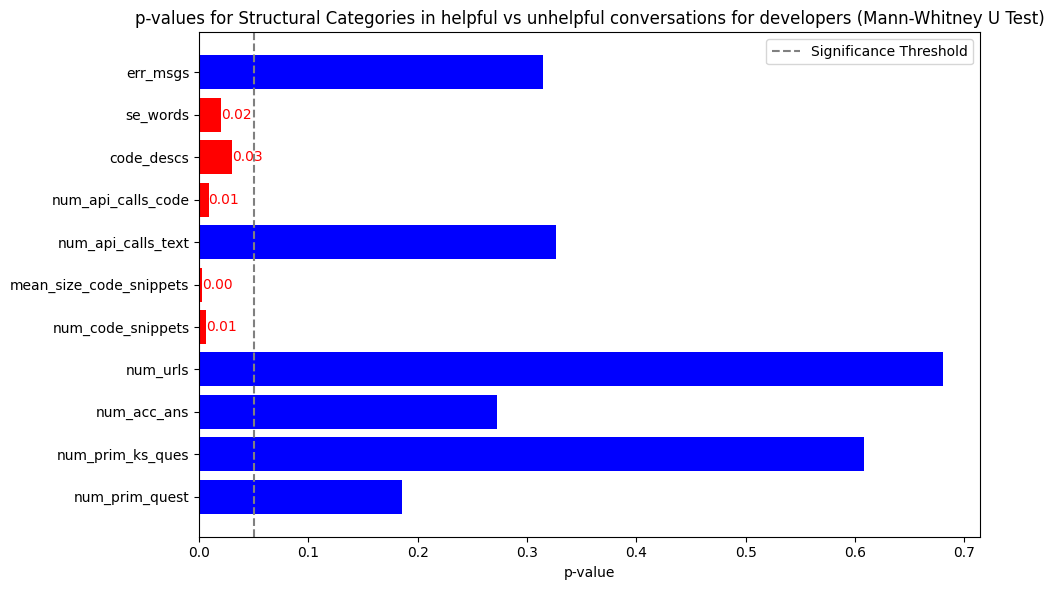

In [8]:
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(np.arange(len(categories_struct)), p_values, color=['red' if sig else 'blue' for sig in significance])
plt.yticks(np.arange(len(categories_struct)), categories_struct)
plt.xlabel('p-value')
plt.title('p-values for Structural Categories in helpful vs unhelpful conversations for developers (Mann-Whitney U Test)')
plt.axvline(x=0.05, color='gray', linestyle='--', label='Significance Threshold')
plt.legend()

# Add labels with color according to significance
for i, (bar, sig) in enumerate(zip(bars, significance)):
    width = bar.get_width()
    if sig:
        plt.text(width, i, f"{width:.2f}", ha='left', va='center', color='red')

# Show plot
plt.tight_layout()
plt.show()

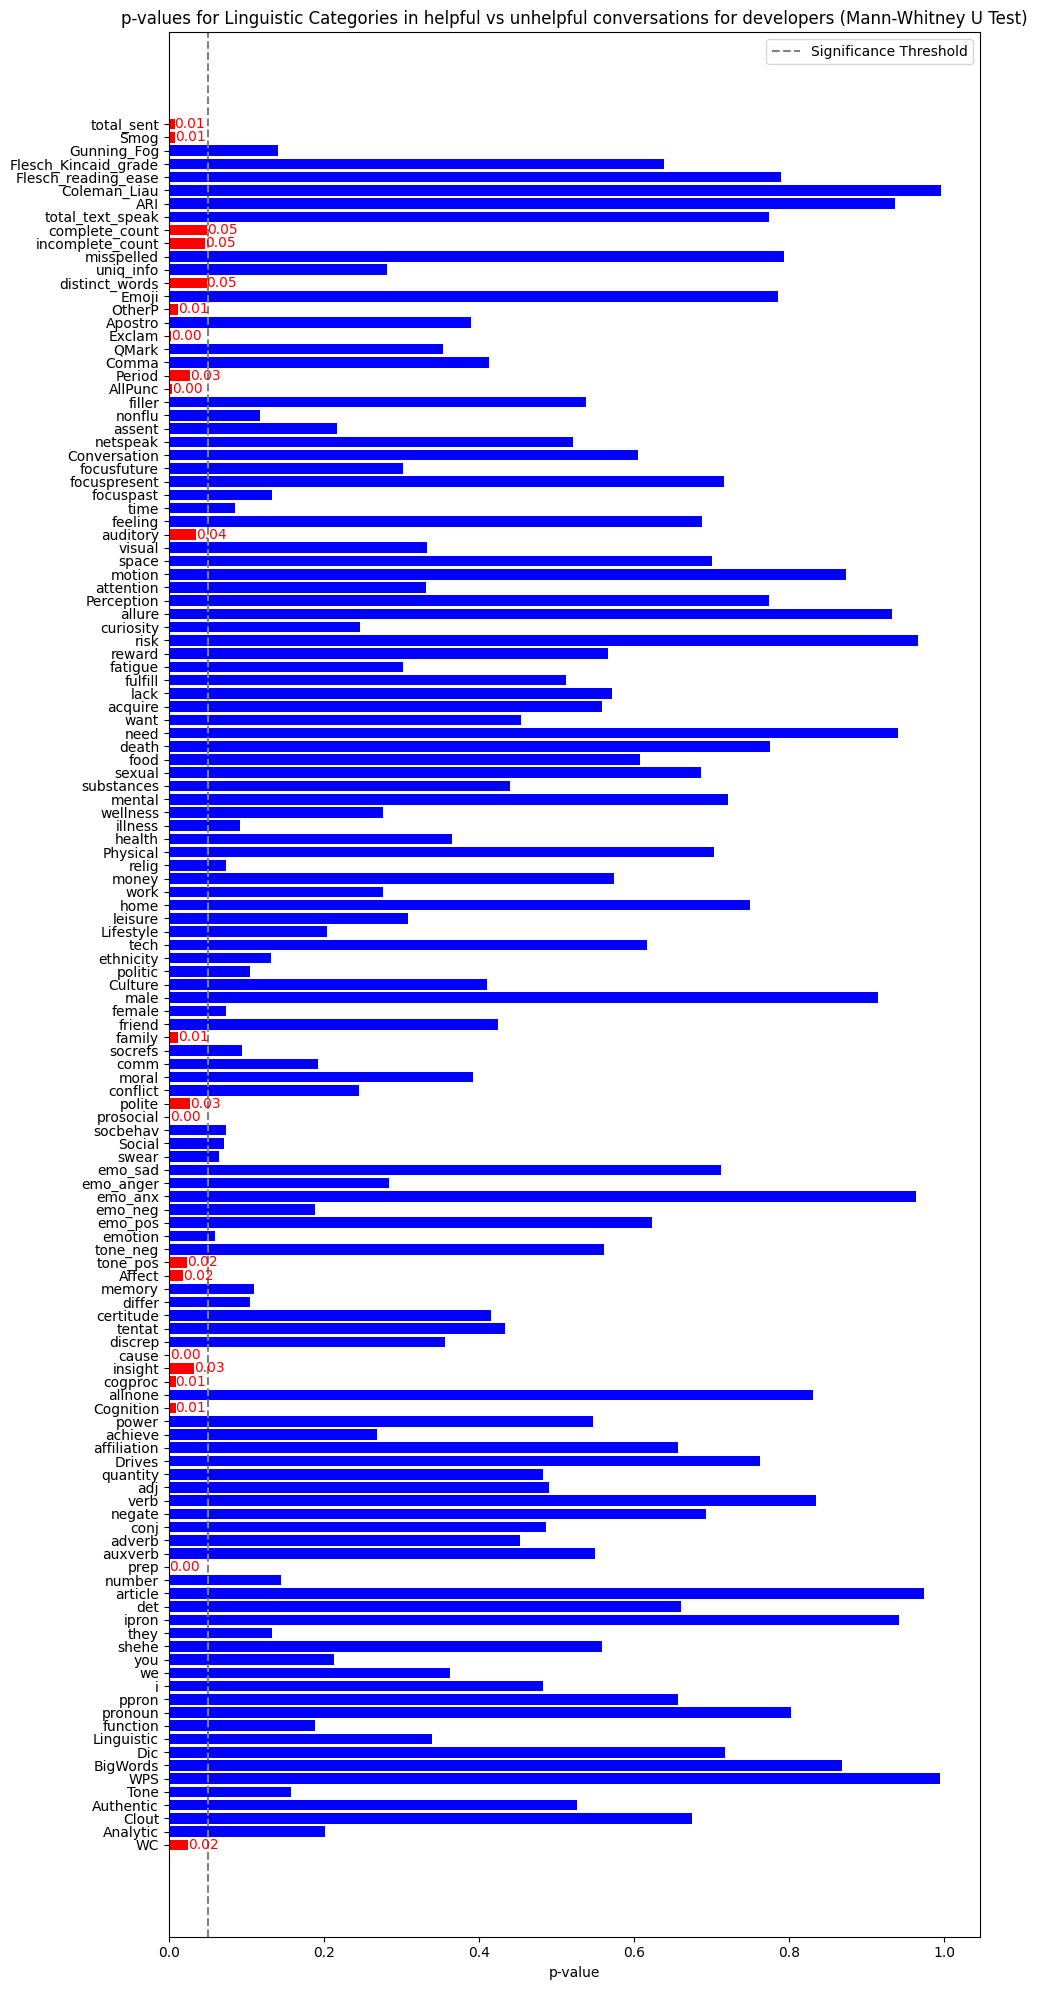

In [9]:
p_values = []
significance = []
for cat in categories_ling:
    dev_liwc_scores1 = developers_data_help[cat]
    dev_liwc_scores2 = developers_data_no_help[cat]


    _, p_value = mannwhitneyu(dev_liwc_scores1, dev_liwc_scores2, alternative='two-sided')
    
    p_values.append(p_value)
    significance.append(p_value < 0.05)
    
# Plotting
plt.figure(figsize=(10, 20))
bars = plt.barh(np.arange(len(categories_ling)), p_values, color=['red' if sig else 'blue' for sig in significance])
plt.yticks(np.arange(len(categories_ling)), categories_ling)
plt.xlabel('p-value')
plt.title('p-values for Linguistic Categories in helpful vs unhelpful conversations for developers (Mann-Whitney U Test)')
plt.axvline(x=0.05, color='gray', linestyle='--', label='Significance Threshold')
plt.legend()

# Add labels with color according to significance
for i, (bar, sig) in enumerate(zip(bars, significance)):
    width = bar.get_width()
    if sig:
        plt.text(width, i, f"{width:.2f}", ha='left', va='center', color='red')

# Show plot
plt.tight_layout()
plt.show()

In [11]:
from scipy.stats import mannwhitneyu
# Lists to store relative differences
relative_differences = []

pos = []
neg = []
# Calculate relative differences for each LIWC category
for cat in categories_struct:
    dev_liwc_scores1 = developers_data_help[cat]
    dev_liwc_scores2 = developers_data_no_help[cat]

    if len(dev_liwc_scores1) == 0 or len(dev_liwc_scores2) == 0:
        print(cat)
    
    mean_dev1 = sum(dev_liwc_scores1) / len(dev_liwc_scores1)
    mean_dev2 = sum(dev_liwc_scores2) / len(dev_liwc_scores2)

    if mean_dev2 == 0.0 and mean_dev1 != 0.0:
        relative_diff = 100
        pos.append(cat)
        relative_differences.append(100)
        continue
    if mean_dev2 == 0.0 and mean_dev1 == 0.0:
        relative_differences.append(0)
        print(cat)
        continue
    
    relative_diff = (mean_dev1 - mean_dev2) / ((mean_dev2))
    if not np.isnan(relative_diff):
        print(cat + " : " + str(relative_diff))
        if relative_diff > 0:
            pos.append(cat)
        elif relative_diff < 0:
            neg.append(cat)

        relative_differences.append(relative_diff)

print("more in helpful:" + str(pos))
print("less in helpful:" + str(neg))

num_prim_quest : 0.22835478751542948
num_prim_ks_ques : -0.020900594732370537
num_urls : 0.16859321200196745
num_code_snippets : 0.11845512892692255
mean_size_code_snippets : -0.13198722757237008
num_api_calls_text : -0.39381210034431874
num_api_calls_code : -0.1453977997723901
code_descs : -0.21698229217904577
se_words : -0.17108051270182048
err_msgs : 0.07809130122214233
more in helpful:['num_prim_quest', 'num_acc_ans', 'num_urls', 'num_code_snippets', 'err_msgs']
less in helpful:['num_prim_ks_ques', 'mean_size_code_snippets', 'num_api_calls_text', 'num_api_calls_code', 'code_descs', 'se_words']


In [12]:
from scipy.stats import mannwhitneyu
# Lists to store relative differences
relative_differences = []

pos = []
neg = []
# Calculate relative differences for each LIWC category
for cat in categories_ling:
    dev_liwc_scores1 = developers_data_help[cat]
    dev_liwc_scores2 = developers_data_no_help[cat]

    if len(dev_liwc_scores1) == 0 or len(dev_liwc_scores2) == 0:
        print(cat)
    
    mean_dev1 = sum(dev_liwc_scores1) / len(dev_liwc_scores1)
    mean_dev2 = sum(dev_liwc_scores2) / len(dev_liwc_scores2)

    if mean_dev2 == 0.0 and mean_dev1 != 0.0:
        relative_differences.append(100)
        continue
    if mean_dev2 == 0.0 and mean_dev1 == 0.0:
        relative_differences.append(0)
        print(cat)
        continue
    
    relative_diff = (mean_dev1 - mean_dev2) / ((mean_dev2))
    if not np.isnan(relative_diff):
        print(cat + " : " + str(relative_diff))
        if relative_diff > 0:
            pos.append(cat)
        elif relative_diff < 0:
            neg.append(cat)

        relative_differences.append(relative_diff)

print("more in helpful:" + str(pos))
print("less in helpful:" + str(neg))

WC : -0.42331065198828655
Analytic : -0.013672418644163556
Clout : 0.029673777987638848
Authentic : -0.06082343765905201
Tone : 0.13391443051793211
WPS : -0.21082936475293773
BigWords : -0.0020816509683197486
Dic : -0.013136153260374737
Linguistic : -0.03541449662175462
function : -0.04150789845823835
pronoun : -0.028064061509208444
ppron : -0.021881494117561642
i : -0.0834369257501537
we : -0.271404572487835
you : 0.3665485014502095
shehe : 0.27835965194972623
they : -0.07085543801226873
ipron : -0.03413295213602353
det : 0.009431409082124776
article : -3.794696098964487e-05
number : 0.053072239089507076
prep : -0.14024042696280656
auxverb : 0.039640191368690444
adverb : -0.06447674004632747
conj : 0.020031186235255065
negate : -0.12955731654197905
verb : 0.0023702119885834426
adj : 0.03549410246685713
quantity : 0.08298265391468773
Drives : -0.06612625352042759
affiliation : -0.06886430826009837
achieve : -0.08628928776632933
power : -0.040474862258135305
Cognition : -0.0993045331134

### GPT

In [36]:
df_prompts = df[df['ColumnID'] == 'answers_fulltext_clean']

In [37]:
categories = [
    "WC", "Analytic", "Clout", "Authentic", "Tone", "WPS", "BigWords", "Dic", "Linguistic", "function", "pronoun",
    "ppron", "i", "we", "you", "shehe", "they", "ipron", "det", "article", "number", "prep", "auxverb", "adverb",
    "conj", "negate", "verb", "adj", "quantity", "Drives", "affiliation", "achieve", "power", "Cognition", "allnone",
    "cogproc", "insight", "cause", "discrep", "tentat", "certitude", "differ", "memory", "Affect", "tone_pos", 
    "tone_neg", "emotion", "emo_pos", "emo_neg", "emo_anx", "emo_anger", "emo_sad", "swear", "Social", "socbehav", 
    "prosocial", "polite", "conflict", "moral", "comm", "socrefs", "family", "friend", "female", "male", "Culture", 
    "politic", "ethnicity", "tech", "Lifestyle", "leisure", "home", "work", "money", "relig", "Physical", "health", 
    "illness", "wellness", "mental", "substances", "sexual", "food", "death", "need", "want", "acquire", "lack", 
    "fulfill", "fatigue", "reward", "risk", "curiosity", "allure", "Perception", "attention", "motion", "space", 
    "visual", "auditory", "feeling", "time", "focuspast", "focuspresent", "focusfuture", "Conversation", "netspeak", 
    "assent", "nonflu", "filler", "AllPunc", "Period", "Comma", "QMark", "Exclam", "Apostro", "OtherP", "Emoji", 
    "num_prim_quest", "num_prim_ks_ques", "num_acc_ans", "num_urls", "num_code_snippets", "mean_size_code_snippets", 
    "num_api_calls_text", "num_api_calls_code", "code_descs", "se_words", "err_msgs", "distinct_words", "uniq_info", 
    "misspelled", "incomplete_count", "complete_count", "total_text_speak", "ARI", "Coleman_Liau", "Flesch_reading_ease", 
    "Flesch_Kincaid_grade", "Gunning_Fog", "Smog", "total_sent"
]

developers_data_help = {
    "WC": [], "Analytic": [], "Clout": [], "Authentic": [], "Tone": [], "WPS": [], "BigWords": [], "Dic": [], "Linguistic": [],
    "function": [], "pronoun": [], "ppron": [], "i": [], "we": [], "you": [], "shehe": [], "they": [], "ipron": [], "det": [],
    "article": [], "number": [], "prep": [], "auxverb": [], "adverb": [], "conj": [], "negate": [], "verb": [], "adj": [],
    "quantity": [], "Drives": [], "affiliation": [], "achieve": [], "power": [], "Cognition": [], "allnone": [], "cogproc": [],
    "insight": [], "cause": [], "discrep": [], "tentat": [], "certitude": [], "differ": [], "memory": [], "Affect": [], "tone_pos": [],
    "tone_neg": [], "emotion": [], "emo_pos": [], "emo_neg": [], "emo_anx": [], "emo_anger": [], "emo_sad": [], "swear": [],
    "Social": [], "socbehav": [], "prosocial": [], "polite": [], "conflict": [], "moral": [], "comm": [], "socrefs": [], "family": [],
    "friend": [], "female": [], "male": [], "Culture": [], "politic": [], "ethnicity": [], "tech": [], "Lifestyle": [], "leisure": [],
    "home": [], "work": [], "money": [], "relig": [], "Physical": [], "health": [], "illness": [], "wellness": [], "mental": [],
    "substances": [], "sexual": [], "food": [], "death": [], "need": [], "want": [], "acquire": [], "lack": [], "fulfill": [],
    "fatigue": [], "reward": [], "risk": [], "curiosity": [], "allure": [], "Perception": [], "attention": [], "motion": [], "space": [],
    "visual": [], "auditory": [], "feeling": [], "time": [], "focuspast": [], "focuspresent": [], "focusfuture": [], "Conversation": [],
    "netspeak": [], "assent": [], "nonflu": [], "filler": [], "AllPunc": [], "Period": [], "Comma": [], "QMark": [], "Exclam": [],
    "Apostro": [], "OtherP": [], "Emoji": [], "num_prim_quest": [], "num_prim_ks_ques": [], "num_acc_ans": [], "num_urls": [],
    "num_code_snippets": [], "mean_size_code_snippets": [], "num_api_calls_text": [], "num_api_calls_code": [], "code_descs": [],
    "se_words": [], "err_msgs": [], "distinct_words": [], "uniq_info": [], "misspelled": [], "incomplete_count": [], "complete_count": [],
    "total_text_speak": [], "ARI": [], "Coleman_Liau": [], "Flesch_reading_ease": [], "Flesch_Kincaid_grade": [], "Gunning_Fog": [],
    "Smog": [], "total_sent": []
}
developers_data_no_help = {
    "WC": [], "Analytic": [], "Clout": [], "Authentic": [], "Tone": [], "WPS": [], "BigWords": [], "Dic": [], "Linguistic": [],
    "function": [], "pronoun": [], "ppron": [], "i": [], "we": [], "you": [], "shehe": [], "they": [], "ipron": [], "det": [],
    "article": [], "number": [], "prep": [], "auxverb": [], "adverb": [], "conj": [], "negate": [], "verb": [], "adj": [],
    "quantity": [], "Drives": [], "affiliation": [], "achieve": [], "power": [], "Cognition": [], "allnone": [], "cogproc": [],
    "insight": [], "cause": [], "discrep": [], "tentat": [], "certitude": [], "differ": [], "memory": [], "Affect": [], "tone_pos": [],
    "tone_neg": [], "emotion": [], "emo_pos": [], "emo_neg": [], "emo_anx": [], "emo_anger": [], "emo_sad": [], "swear": [],
    "Social": [], "socbehav": [], "prosocial": [], "polite": [], "conflict": [], "moral": [], "comm": [], "socrefs": [], "family": [],
    "friend": [], "female": [], "male": [], "Culture": [], "politic": [], "ethnicity": [], "tech": [], "Lifestyle": [], "leisure": [],
    "home": [], "work": [], "money": [], "relig": [], "Physical": [], "health": [], "illness": [], "wellness": [], "mental": [],
    "substances": [], "sexual": [], "food": [], "death": [], "need": [], "want": [], "acquire": [], "lack": [], "fulfill": [],
    "fatigue": [], "reward": [], "risk": [], "curiosity": [], "allure": [], "Perception": [], "attention": [], "motion": [], "space": [],
    "visual": [], "auditory": [], "feeling": [], "time": [], "focuspast": [], "focuspresent": [], "focusfuture": [], "Conversation": [],
    "netspeak": [], "assent": [], "nonflu": [], "filler": [], "AllPunc": [], "Period": [], "Comma": [], "QMark": [], "Exclam": [],
    "Apostro": [], "OtherP": [], "Emoji": [], "num_prim_quest": [], "num_prim_ks_ques": [], "num_acc_ans": [], "num_urls": [],
    "num_code_snippets": [], "mean_size_code_snippets": [], "num_api_calls_text": [], "num_api_calls_code": [], "code_descs": [],
    "se_words": [], "err_msgs": [], "distinct_words": [], "uniq_info": [], "misspelled": [], "incomplete_count": [], "complete_count": [],
    "total_text_speak": [], "ARI": [], "Coleman_Liau": [], "Flesch_reading_ease": [], "Flesch_Kincaid_grade": [], "Gunning_Fog": [],
    "Smog": [], "total_sent": []
}

for index, row in df_prompts.iterrows():
    for cat in categories:
        if not np.isnan(row[cat]):
            if row['Did ChatGPT help with the issue'] == 'No':
                developers_data_no_help[cat].append(row[cat])
            elif row['Did ChatGPT help with the issue'] == 'Yes':
                developers_data_help[cat].append(row[cat])

In [38]:
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

p_values = []
significance = []

categories_struct = ["num_prim_quest", "num_prim_ks_ques", "num_acc_ans", "num_urls", "num_code_snippets", "mean_size_code_snippets", 
    "num_api_calls_text", "num_api_calls_code", "code_descs", "se_words", "err_msgs"]
categories_ling = ["WC", "Analytic", "Clout", "Authentic", "Tone", "WPS", "BigWords", "Dic", "Linguistic", "function", "pronoun",
    "ppron", "i", "we", "you", "shehe", "they", "ipron", "det", "article", "number", "prep", "auxverb", "adverb",
    "conj", "negate", "verb", "adj", "quantity", "Drives", "affiliation", "achieve", "power", "Cognition", "allnone",
    "cogproc", "insight", "cause", "discrep", "tentat", "certitude", "differ", "memory", "Affect", "tone_pos", 
    "tone_neg", "emotion", "emo_pos", "emo_neg", "emo_anx", "emo_anger", "emo_sad", "swear", "Social", "socbehav", 
    "prosocial", "polite", "conflict", "moral", "comm", "socrefs", "family", "friend", "female", "male", "Culture", 
    "politic", "ethnicity", "tech", "Lifestyle", "leisure", "home", "work", "money", "relig", "Physical", "health", 
    "illness", "wellness", "mental", "substances", "sexual", "food", "death", "need", "want", "acquire", "lack", 
    "fulfill", "fatigue", "reward", "risk", "curiosity", "allure", "Perception", "attention", "motion", "space", 
    "visual", "auditory", "feeling", "time", "focuspast", "focuspresent", "focusfuture", "Conversation", "netspeak", 
    "assent", "nonflu", "filler", "AllPunc", "Period", "Comma", "QMark", "Exclam", "Apostro", "OtherP", "Emoji","distinct_words", "uniq_info", 
    "misspelled", "incomplete_count", "complete_count", "total_text_speak", "ARI", "Coleman_Liau", "Flesch_reading_ease", 
    "Flesch_Kincaid_grade", "Gunning_Fog", "Smog", "total_sent"]


for cat in categories_struct:
    dev_liwc_scores1 = developers_data_help[cat]
    dev_liwc_scores2 = developers_data_no_help[cat]


    _, p_value = mannwhitneyu(dev_liwc_scores1, dev_liwc_scores2, alternative='two-sided')

    # Output results
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print(cat + ": Statistically significant difference")
    else:
        print(cat + ": No statistically significant difference")
    
    p_values.append(p_value)
    significance.append(p_value < 0.05)
    
    print("")

p-value: 0.8673871413974952
num_prim_quest: No statistically significant difference

p-value: 0.0666208417203894
num_prim_ks_ques: No statistically significant difference

p-value: 0.19879951151995545
num_acc_ans: No statistically significant difference

p-value: 0.5892564062942115
num_urls: No statistically significant difference

p-value: 0.02592059939547282
num_code_snippets: Statistically significant difference

p-value: 0.20238985554408206
mean_size_code_snippets: No statistically significant difference

p-value: 0.26475915297990693
num_api_calls_text: No statistically significant difference

p-value: 0.8844254909135866
num_api_calls_code: No statistically significant difference

p-value: 0.10472391436727603
code_descs: No statistically significant difference

p-value: 0.4203301273043114
se_words: No statistically significant difference

p-value: 1.0
err_msgs: No statistically significant difference



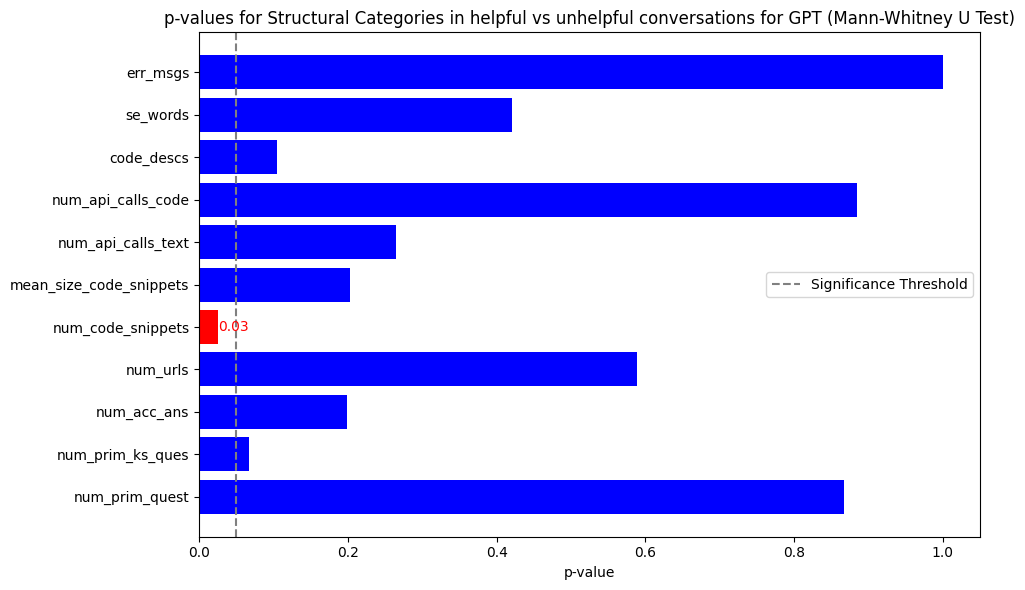

In [39]:
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(np.arange(len(categories_struct)), p_values, color=['red' if sig else 'blue' for sig in significance])
plt.yticks(np.arange(len(categories_struct)), categories_struct)
plt.xlabel('p-value')
plt.title('p-values for Structural Categories in helpful vs unhelpful conversations for GPT (Mann-Whitney U Test)')
plt.axvline(x=0.05, color='gray', linestyle='--', label='Significance Threshold')
plt.legend()

# Add labels with color according to significance
for i, (bar, sig) in enumerate(zip(bars, significance)):
    width = bar.get_width()
    if sig:
        plt.text(width, i, f"{width:.2f}", ha='left', va='center', color='red')

# Show plot
plt.tight_layout()
plt.show()

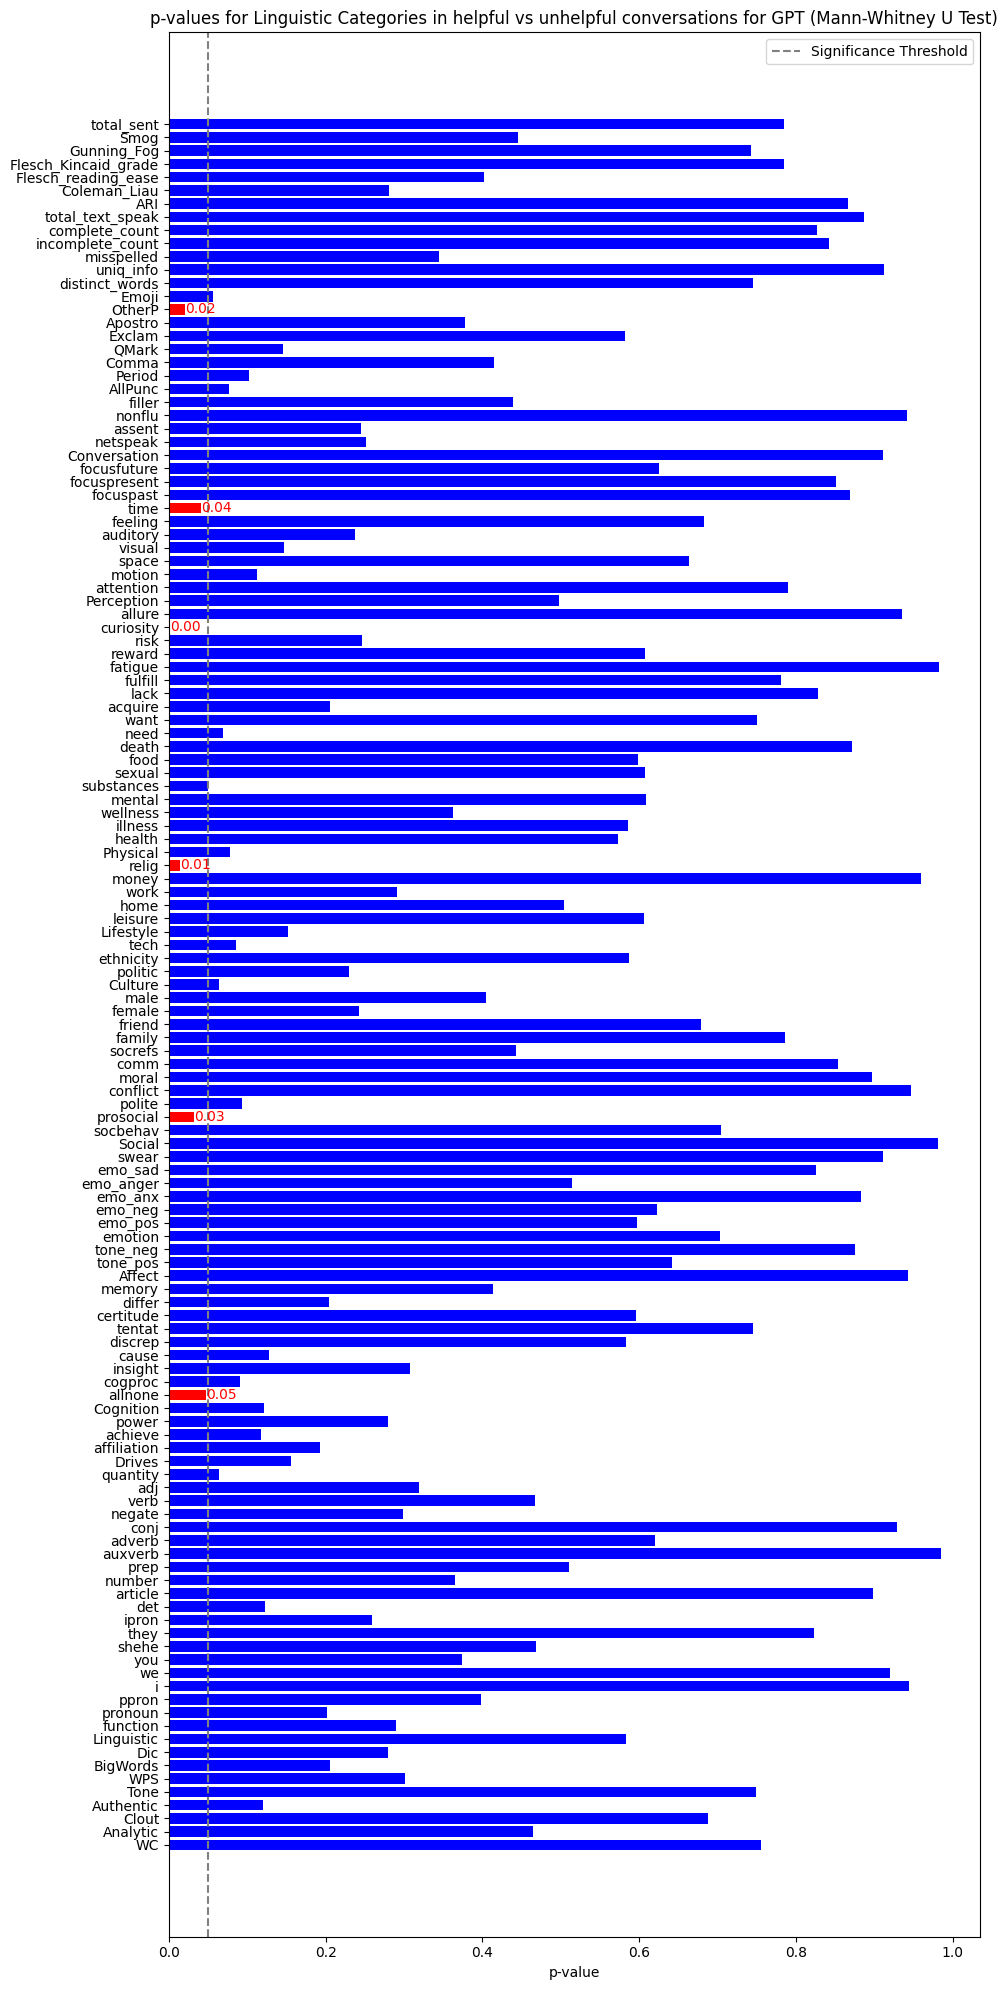

In [40]:
p_values = []
significance = []
for cat in categories_ling:
    dev_liwc_scores1 = developers_data_help[cat]
    dev_liwc_scores2 = developers_data_no_help[cat]


    _, p_value = mannwhitneyu(dev_liwc_scores1, dev_liwc_scores2, alternative='two-sided')
    
    p_values.append(p_value)
    significance.append(p_value < 0.05)
    
# Plotting
plt.figure(figsize=(10, 20))
bars = plt.barh(np.arange(len(categories_ling)), p_values, color=['red' if sig else 'blue' for sig in significance])
plt.yticks(np.arange(len(categories_ling)), categories_ling)
plt.xlabel('p-value')
plt.title('p-values for Linguistic Categories in helpful vs unhelpful conversations for GPT (Mann-Whitney U Test)')
plt.axvline(x=0.05, color='gray', linestyle='--', label='Significance Threshold')
plt.legend()

# Add labels with color according to significance
for i, (bar, sig) in enumerate(zip(bars, significance)):
    width = bar.get_width()
    if sig:
        plt.text(width, i, f"{width:.2f}", ha='left', va='center', color='red')

# Show plot
plt.tight_layout()
plt.show()

In [41]:
from scipy.stats import mannwhitneyu
# Lists to store relative differences
relative_differences = []

pos = []
neg = []
# Calculate relative differences for each LIWC category
for cat in categories_struct:
    dev_liwc_scores1 = developers_data_help[cat]
    dev_liwc_scores2 = developers_data_no_help[cat]

    if len(dev_liwc_scores1) == 0 or len(dev_liwc_scores2) == 0:
        print(cat)
    
    mean_dev1 = sum(dev_liwc_scores1) / len(dev_liwc_scores1)
    mean_dev2 = sum(dev_liwc_scores2) / len(dev_liwc_scores2)

    if mean_dev2 == 0.0 and mean_dev1 != 0.0:
        relative_diff = 100
        pos.append(cat)
        relative_differences.append(100)
        continue
    if mean_dev2 == 0.0 and mean_dev1 == 0.0:
        relative_differences.append(0)
        print(cat)
        continue
    
    relative_diff = (mean_dev1 - mean_dev2) / ((mean_dev2))
    if not np.isnan(relative_diff):
        print(cat + " : " + str(relative_diff))
        if relative_diff > 0:
            pos.append(cat)
        elif relative_diff < 0:
            neg.append(cat)

        relative_differences.append(relative_diff)

print("more in helpful:" + str(pos))
print("less in helpful:" + str(neg))

num_prim_quest : -0.3747872007782372
num_prim_ks_ques : -0.5615972812234494
num_acc_ans : -1.0
num_urls : -0.1789397357396069
num_code_snippets : 0.28840576393338946
mean_size_code_snippets : 0.04358189451424854
num_api_calls_text : 0.14966281414662697
num_api_calls_code : -0.023636415680325137
code_descs : 0.0511095204753319
se_words : 0.0014565256826764338
err_msgs
more in helpful:['num_code_snippets', 'mean_size_code_snippets', 'num_api_calls_text', 'code_descs', 'se_words']
less in helpful:['num_prim_quest', 'num_prim_ks_ques', 'num_acc_ans', 'num_urls', 'num_api_calls_code']


In [42]:
from scipy.stats import mannwhitneyu
# Lists to store relative differences
relative_differences = []

pos = []
neg = []
# Calculate relative differences for each LIWC category
for cat in categories_ling:
    dev_liwc_scores1 = developers_data_help[cat]
    dev_liwc_scores2 = developers_data_no_help[cat]

    if len(dev_liwc_scores1) == 0 or len(dev_liwc_scores2) == 0:
        print(cat)
    
    mean_dev1 = sum(dev_liwc_scores1) / len(dev_liwc_scores1)
    mean_dev2 = sum(dev_liwc_scores2) / len(dev_liwc_scores2)

    if mean_dev2 == 0.0 and mean_dev1 != 0.0:
        relative_differences.append(100)
        continue
    if mean_dev2 == 0.0 and mean_dev1 == 0.0:
        relative_differences.append(0)
        print(cat)
        continue
    
    relative_diff = (mean_dev1 - mean_dev2) / ((mean_dev2))
    if not np.isnan(relative_diff):
        print(cat + " : " + str(relative_diff))
        if relative_diff > 0:
            pos.append(cat)
        elif relative_diff < 0:
            neg.append(cat)

        relative_differences.append(relative_diff)

print("more in helpful:" + str(pos))
print("less in helpful:" + str(neg))

WC : 0.01482761169560498
Analytic : -0.008910342832638479
Clout : 0.012575035232135302
Authentic : 0.08002504255011987
Tone : -0.010363238931187579
WPS : 0.04469113381929515
BigWords : -0.03865472576140072
Dic : 0.0042194537474439155
Linguistic : -0.0070315317341571775
function : -0.004010226697830018
pronoun : 0.027567233931361897
ppron : 0.027613474741791252
i : -0.025428365672812182
we : -0.08749015866546919
you : 0.03887531729904132
shehe : 0.42895706892057955
they : 0.01817777291551169
ipron : 0.0275045009379345
det : 0.011219665397254207
article : -0.00441324570012315
number : -0.0073721300673448955
prep : -0.01563243814180757
auxverb : -0.010444441678711192
adverb : 0.0031988516824444833
conj : -0.005054513781606354
negate : 0.029540609270028145
verb : -0.013198696496800492
adj : -0.037095655459782474
quantity : 0.08028524297285501
Drives : -0.055246277963047125
affiliation : -0.12284416063924469
achieve : -0.07940782893336473
power : 0.0039268609252595165
Cognition : -0.0307073

# RQ2, Repo Parameters

In [45]:
import pandas as pd
from scipy.stats import mannwhitneyu

combined_df = pd.read_csv('../datasets/conversations_repo_parameters.csv')
# Separate the data based on the "Did ChatGPT help with the issue" column
combined_df_helpful = combined_df[combined_df["Did ChatGPT help with the issue"] == "Yes"]
combined_df_unhelpful = combined_df[combined_df["Did ChatGPT help with the issue"] == "No"]

# Features to compare
features = [
    "stars", "contributors", "forks", "num_files", "num_lines",
    "user_public_repos", "user_followers", "user_account_age_years", "user_contributions"
]

results = []

# Perform Mann-Whitney U test and calculate the relative difference
for feature in features:
    stat, p_value = mannwhitneyu(combined_df_helpful[feature].dropna(), combined_df_unhelpful[feature].dropna())
    median_helpful = combined_df_helpful[feature].median()
    median_unhelpful = combined_df_unhelpful[feature].median()
    relative_difference = (median_helpful - median_unhelpful) / ((median_helpful + median_unhelpful) / 2)
    
    higher_in = "Helpful" if relative_difference > 0 else "Unhelpful"
    
    results.append({
        "Feature": feature,
        "P-Value": p_value,
        "Median (Helpful)": median_helpful,
        "Median (Unhelpful)": median_unhelpful,
        "Relative Difference": relative_difference,
        "Higher in": higher_in
    })

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)

# Filter for statistically significant features (e.g., p-value < 0.05)
# significant_results = results_df[results_df["P-Value"] < 0.05]

results_df.head()

,Feature,P-Value,Median (Helpful),Median (Unhelpful),Relative Difference,Higher in
0,stars,0.732542,25.0,19.0,0.272727,Helpful
1,contributors,0.393131,5.0,5.0,0.000000,Unhelpful
2,forks,0.838023,6.0,6.0,0.000000,Unhelpful
3,num_files,0.000285,94.0,62.5,0.402556,Helpful
4,num_lines,0.000820,17435.0,8119.0,0.729123,Helpful


# RQ2, Discourse

### Lexico-semantic

In [ ]:
df_help = df[df['Did ChatGPT help with the issue'] == 'Yes']
df_no_help = df[df['Did ChatGPT help with the issue'] == 'No']

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  # You can choose other models as well

In [ ]:
# Adapted from https://gist.github.com/winzig/8894715

url_re = r"""
(?xi)
\b
(                                       # Capture 1: entire matched URL
  (?:
    https?:                             # URL protocol and colon
    (?:
      /{1,3}                            # 1-3 slashes
      |                                 #   or
      [a-z0-9%]                         # Single letter or digit or '%'
                                        # (Trying not to match e.g. "URI::Escape")
    )
    |                                   #   or
                                        # looks like domain name followed by a slash:
    [a-z0-9.\-]+[.]
    (?:[a-z]{2,13})
    /
  )
  (?:                                   # One or more:
    [^\s()<>{}\[\]]+                    # Run of non-space, non-()<>{}[]
    |                                   #   or
    \([^\s()]*?\([^\s()]+\)[^\s()]*?\)  # balanced parens, one level deep: (…(…)…)
    |
    \([^\s]+?\)                         # balanced parens, non-recursive: (…)
  )+
  (?:                                   # End with:
    \([^\s()]*?\([^\s()]+\)[^\s()]*?\)  # balanced parens, one level deep: (…(…)…)
    |
    \([^\s]+?\)                         # balanced parens, non-recursive: (…)
    |                                   #   or
    [^\s`!()\[\]{};:'".,<>?«»“”‘’]      # not a space or one of these punct chars
  )
  |                                     # OR, the following to match naked domains:
  (?:\b
    (?<![@.])                           # not preceded by a @, avoid matching foo@_gmail.com_
    [a-z0-9]+
    (?:[.\-][a-z0-9]+)*
    [.]
    (?:[a-z]{2,13})
    \b
    /?
    (?!@)                               # not succeeded by a @, avoid matching "foo.na" in "foo.na@example.com"
    /                                   # nkraft: followed by a slash to avoid field or method accesses (e.g., Set.size)
  )
)
"""

import pandas as pd
import re

def replace_code_error(prompts, codes, code_blocks, errors):
    for i in range(len(prompts)):
        for code in codes:
            if len(code) == 0 or len(code) == 1:
                continue
            prompts[i] = prompts[i].replace(code, '[CODE]', 1)
        for code_block in code_blocks:
            if len(code_block) == 0 or len(code_block) == 1:
                continue
            prompts[i] = prompts[i].replace(code_block, '[CODE]', 1)
        for error in errors:
            if len(error) == 0 or len(error) == 1:
                continue
            prompts[i] = prompts[i].replace(error, '[ERROR]', 1)
        prompts[i] = re.sub(url_re, '[URL]', prompts[i])
    return prompts

def replace_code(answers, codes):
    for i in range(len(answers)):
        for code in codes:
            if len(code) == 0 or len(code) == 1:
                continue
            answers[i] = answers[i].replace(code, '[CODE]', 1)
        answers[i] = re.sub(url_re, '[URL]', answers[i])
    return answers

# Create new columns for cleaned prompts and answers
df['prompts_list_clean'] = df.apply(lambda row: replace_code_error(row['prompts'], row['prompts_codes'], row['prompts_code_blocks'], row['prompts_errors']), axis=1)
df['answers_list_clean'] = df.apply(lambda row: replace_code(row['answers'], row['answers_codes']), axis=1)

df.head(n=10)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Assuming df_help and df_no_help have 'prompts' and 'answers' columns with lists of prompts and answers

def calculate_cumulative_cosine_similarity(prompts, answers):
    prompt_embeddings = [model.encode(prompt) for prompt in prompts]
    answer_embeddings = [model.encode(answer) for answer in answers]
    
    cumulative_prompt_embedding = np.zeros_like(prompt_embeddings[0])
    cumulative_answer_embedding = np.zeros_like(answer_embeddings[0])
    
    similarities = []
    for i in range(0, len(prompts)):
        if i >= len(answers):
            break
        cumulative_prompt_embedding += prompt_embeddings[i]
        cumulative_answer_embedding += answer_embeddings[i]
        similarity = cosine_similarity([cumulative_prompt_embedding], [cumulative_answer_embedding])[0][0]
        similarities.append(similarity)
    
    return similarities

# Calculate cumulative cosine similarity for each conversation
cumulative_similarity_help = []
cumulative_similarity_no_help = []

for _, row in df_help.iterrows():
    if row['ColumnID'] == 'prompts_fulltext_clean':
        print(_)
        similarity_progression = calculate_cumulative_cosine_similarity(row['prompts_list_clean'], row['answers_list_clean'])
        cumulative_similarity_help.append(similarity_progression)

for _, row in df_no_help.iterrows():
    if row['ColumnID'] == 'prompts_fulltext_clean':
        print(_)
        similarity_progression = calculate_cumulative_cosine_similarity(row['prompts_list_clean'], row['answers_list_clean'])
        cumulative_similarity_no_help.append(similarity_progression)

### Topic coherence

In [ ]:
import pandas as pd
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Apply preprocessing to lists of prompts and answers
df_help['processed_prompts_coherence'] = df_help['prompts_list_clean'].apply(lambda x: [preprocess(p) for p in x])
df_help['processed_answers_coherence'] = df_help['answers_list_clean'].apply(lambda x: [preprocess(a) for a in x])
df_no_help['processed_prompts_coherence'] = df_no_help['prompts_list_clean'].apply(lambda x: [preprocess(p) for p in x])
df_no_help['processed_answers_coherence'] = df_no_help['answers_list_clean'].apply(lambda x: [preprocess(a) for a in x])

In [ ]:
# Function to calculate coherence score for a list of processed texts
def calculate_coherence(processed_texts):
    dictionary = Dictionary(processed_texts)
    corpus = [dictionary.doc2bow(text) for text in processed_texts]
    lda_model = LdaModel(corpus, num_topics=1, id2word=dictionary, passes=10)
    coherence_model = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()


# Calculate coherence progression considering at most the last two pairs of prompts and answers
def calculate_coherence_progression(processed_prompts, processed_answers):
    coherence_scores = {'prompt+answer': []}
    cumulative_prompts = []
    cumulative_answers = []

    for prompt, answer in zip(processed_prompts, processed_answers):
        cumulative_prompts.append(prompt)
        cumulative_answers.append(answer)

        # Consider at most the last two pairs
        if len(cumulative_prompts) > 2:
            texts_to_consider = cumulative_prompts[-2:] + cumulative_answers[-2:]
            # print(texts_to_consider)
            # break
        else:
            texts_to_consider = cumulative_prompts + cumulative_answers

        coherence_scores['prompt+answer'].append(calculate_coherence(texts_to_consider))

    return coherence_scores

# Initialize lists to store coherence progressions
coherence_progression_help = []
coherence_progression_no_help = []

# Calculate coherence progressions for helpful conversations
for idx, row in df_help.iterrows():
    print(idx)
    coherence_scores = calculate_coherence_progression(row['processed_prompts_coherence'], row['processed_answers_coherence'])
    coherence_progression_help.append(coherence_scores)

# Calculate coherence progressions for unhelpful conversations
for idx, row in df_no_help.iterrows():
    print(idx)
    coherence_scores = calculate_coherence_progression(row['processed_prompts_coherence'], row['processed_answers_coherence'])
    coherence_progression_no_help.append(coherence_scores)

In [ ]:
coherence_progression_help_without_dup = [item for index, item in enumerate(coherence_progression_help) if index % 2 == 0]
coherence_progression_no_help_without_dup = [item for index, item in enumerate(coherence_progression_no_help) if index % 2 == 0]

### LSM

In [ ]:
new_df = pd.read_csv('../datasets/conversation_analysis/LIWC_conversation_progression.csv')

categories = [
    "article", "conj", "ipron", "negate", "prep", "adverb", "auxverb", "ppron"
]

# Initialize cumulative similarity lists
cumulative_lsm_help = []
cumulative_lsm_no_help = []

# Iterate over each chat_id to calculate LSM progressively
for chat_id, group in new_df.groupby('chat_id'):
    # Separate the prompts and answers
    prompts = group[group['ColumnID'] == 'prompt'].sort_values('step')
    answers = group[group['ColumnID'] == 'answer'].sort_values('step')

    # Initialize cumulative lists
    cum_help = []
    cum_no_help = []

    # Iterate through steps
    for step in range(1, len(prompts) + 1):
        lsm_scores = []
        
        # Calculate LSM for prompt-answer, answer-next prompt, and so on
        if step == 1:
            prompt_val = prompts.iloc[step-1]
            answer_val = answers.iloc[step-1]
            for category in categories:
                prompt_category_val = prompt_val[category]
                answer_category_val = answer_val[category]
                lsm = 1 - abs(prompt_category_val - answer_category_val) / (prompt_category_val + answer_category_val + 0.0001)
                lsm_scores.append(lsm)
            lsm_avg = sum(lsm_scores) / len(lsm_scores)

            if prompts.iloc[step-1]['help'] == 'Yes':
                cum_help.append(lsm_avg)
            else:
                cum_no_help.append(lsm_avg)
        else:
            prompt_val = prompts.iloc[step-1]
            answer_val = answers.iloc[step-1]

            for category in categories:
                prompt_category_val = prompt_val[category]
                answer_category_val = answer_val[category]
                lsm = 1 - abs(prompt_category_val - answer_category_val) / (prompt_category_val + answer_category_val + 0.0001)
                lsm_scores.append(lsm)
            lsm_avg = sum(lsm_scores) / len(lsm_scores)

            if prompts.iloc[step-1]['help'] == 'Yes':
                cum_help.append(lsm_avg)
            else:
                cum_no_help.append(lsm_avg)
            
            prompt_val = prompts.iloc[step-1]
            answer_val = answers.iloc[step-2]
            for category in categories:
                prompt_category_val = prompt_val[category]
                answer_category_val = answer_val[category]
                lsm = 1 - abs(prompt_category_val - answer_category_val) / (prompt_category_val + answer_category_val + 0.0001)
                lsm_scores.append(lsm)
            lsm_avg = sum(lsm_scores) / len(lsm_scores)
            if prompts.iloc[step-1]['help'] == 'Yes':
                cum_help.append(lsm_avg)
            else:
                cum_no_help.append(lsm_avg)
    if len(cum_help) != 0:
        cumulative_lsm_help.append(cum_help)
    if len(cum_no_help) != 0:
        cumulative_lsm_no_help.append(cum_no_help)

### plot

In [14]:
import pickle

# Load the dictionaries
with open('../pickle_files/topic_coherence_help.pkl', 'rb') as file:
    coherence_progression_help_without_dup = pickle.load(file)

with open('../pickle_files/topic_coherence_no_help.pkl', 'rb') as file:
    coherence_progression_no_help_without_dup = pickle.load(file)

with open('../pickle_files/lss_help.pkl', 'rb') as file:
    cumulative_similarity_help = pickle.load(file)

with open('../pickle_files/lss_no_help.pkl', 'rb') as file:
    cumulative_similarity_no_help = pickle.load(file)

with open('../pickle_files/lsm_help.pkl', 'rb') as file:
    cumulative_lsm_help = pickle.load(file)

with open('../pickle_files/lsm_no_help.pkl', 'rb') as file:
    cumulative_lsm_no_help = pickle.load(file)

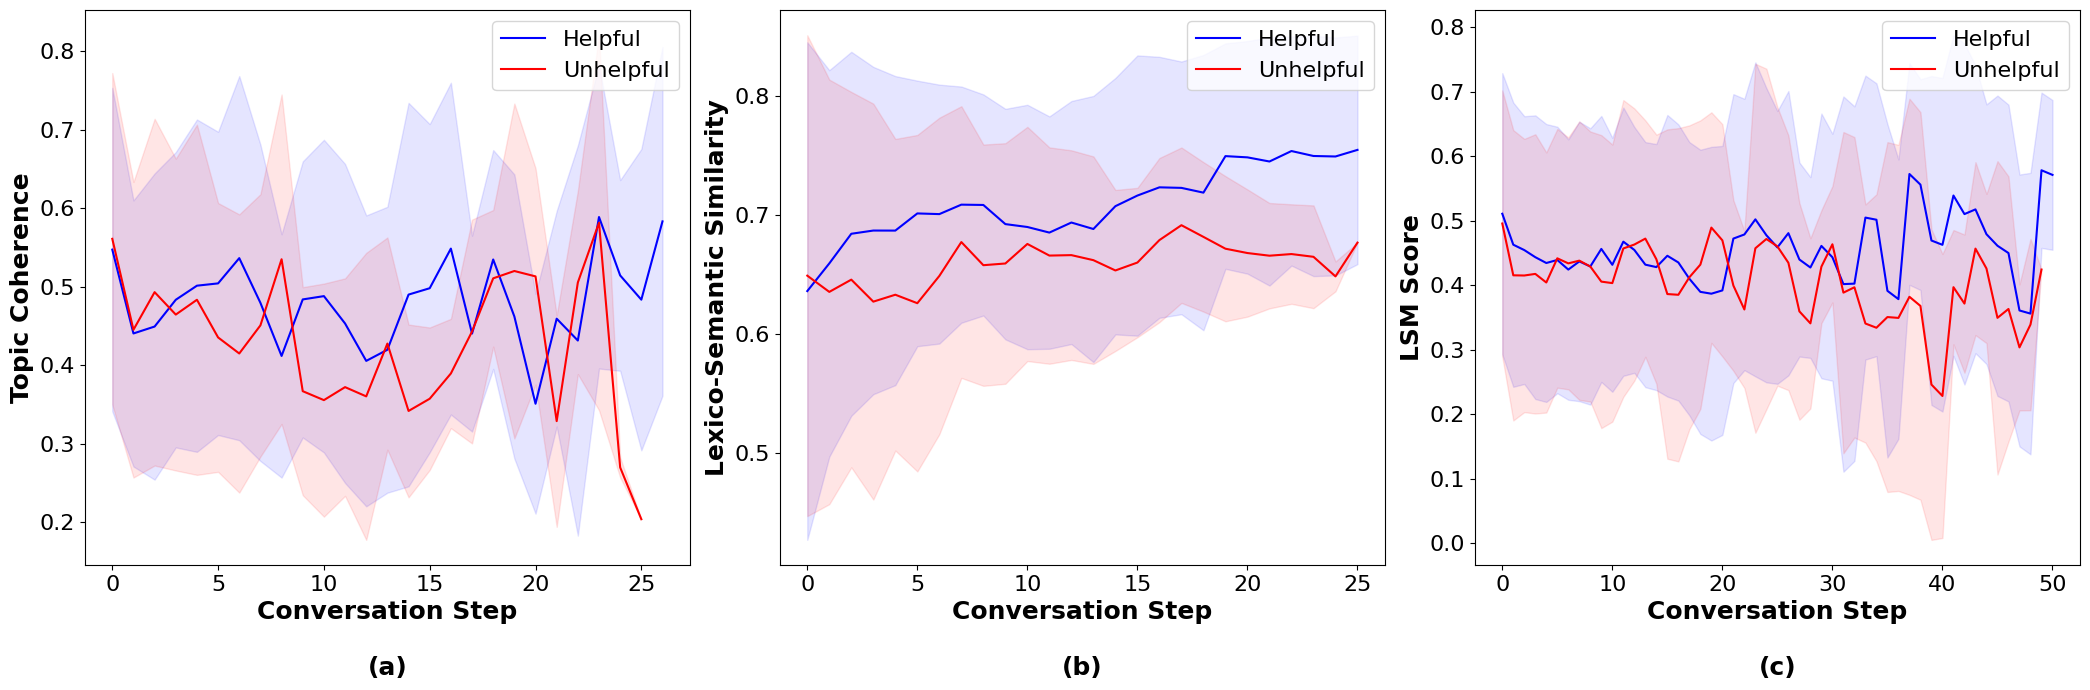

In [58]:
# import numpy as np
# import matplotlib.pyplot as plt

def calculate_average_progression1(coherence_progressions, n=0):
    max_length = max(len(scores['prompt+answer']) for scores in coherence_progressions) - n
    avg_prompts = np.zeros(max_length)
    std_prompts = np.zeros(max_length)
    
    for i in range(max_length):
        step_prompts = [scores['prompt+answer'][i] for scores in coherence_progressions if i < len(scores['prompt+answer'])]
        avg_prompts[i] = np.mean(step_prompts)
        std_prompts[i] = np.std(step_prompts)
    
    return avg_prompts, std_prompts

# Define the function to calculate average progression and standard deviation
def calculate_average_progression(lsm_progressions, n=0):
    max_length = max(len(similarity) for similarity in lsm_progressions)-n
    avg_similarity = np.zeros(max_length)
    std_similarity = np.zeros(max_length)
    
    for i in range(max_length):
        step_similarities = [similarity[i] for similarity in lsm_progressions if i < len(similarity)]
        avg_similarity[i] = np.mean(step_similarities)
        std_similarity[i] = np.std(step_similarities)
    
    return avg_similarity, std_similarity

# Calculate average and std for coherence
avg_prompts_help, std_prompts_help = calculate_average_progression1(coherence_progression_help_without_dup, 82)
avg_prompts_no_help, std_prompts_no_help = calculate_average_progression1(coherence_progression_no_help_without_dup, 15)

# Calculate average and std for cosine similarity
avg_similarity_help, std_similarity_help = calculate_average_progression(cumulative_similarity_help, 83)
avg_similarity_no_help, std_similarity_no_help = calculate_average_progression(cumulative_similarity_no_help, 15)

# Calculate average and std for LSM
avg_lsm_help, std_lsm_help = calculate_average_progression(cumulative_lsm_help, 166)
avg_lsm_no_help, std_lsm_no_help = calculate_average_progression(cumulative_lsm_no_help, 31)

# Plot the subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Subplot 1: Coherence progression
axs[0].plot(avg_prompts_help, label='Helpful', color='blue')
axs[0].fill_between(range(len(avg_prompts_help)), avg_prompts_help - std_prompts_help, avg_prompts_help + std_prompts_help, color='blue', alpha=0.1)
axs[0].plot(avg_prompts_no_help, label='Unhelpful', color='red')
axs[0].fill_between(range(len(avg_prompts_no_help)), avg_prompts_no_help - std_prompts_no_help, avg_prompts_no_help + std_prompts_no_help, color='red', alpha=0.1)
# axs[0].set_title('', fontsize=16, fontweight='bold')
axs[0].set_xlabel('Conversation Step\n\n(a)', fontsize=18, fontweight='bold')
axs[0].set_ylabel('Topic Coherence', fontsize=18, fontweight='bold')
axs[0].legend(fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=16)

# Subplot 2: Cosine similarity progression
axs[1].plot(avg_similarity_help, label='Helpful', color='blue')
axs[1].fill_between(range(len(avg_similarity_help)), avg_similarity_help - std_similarity_help, avg_similarity_help + std_similarity_help, color='blue', alpha=0.1)
axs[1].plot(avg_similarity_no_help, label='Unhelpful', color='red')
axs[1].fill_between(range(len(avg_similarity_no_help)), avg_similarity_no_help - std_similarity_no_help, avg_similarity_no_help + std_similarity_no_help, color='red', alpha=0.1)
# axs[1].set_title('(b)', fontsize=16, fontweight='bold')
axs[1].set_xlabel('Conversation Step\n\n(b)', fontsize=18, fontweight='bold')
axs[1].set_ylabel('Lexico-Semantic Similarity', fontsize=18, fontweight='bold')
axs[1].legend(fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)

# Subplot 3: LSM progression
axs[2].plot(avg_lsm_help, label='Helpful', color='blue')
axs[2].fill_between(range(len(avg_lsm_help)), avg_lsm_help - std_lsm_help, avg_lsm_help + std_lsm_help, color='blue', alpha=0.1)
axs[2].plot(avg_lsm_no_help, label='Unhelpful', color='red')
axs[2].fill_between(range(len(avg_lsm_no_help)), avg_lsm_no_help - std_lsm_no_help, avg_lsm_no_help + std_lsm_no_help, color='red', alpha=0.1)
# axs[2].set_title('(c)', fontsize=16, fontweight='bold')
axs[2].set_xlabel('Conversation Step\n\n(c)', fontsize=18, fontweight='bold')
axs[2].set_ylabel('Linguistic Style Matching', fontsize=18, fontweight='bold')
axs[2].legend(fontsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
# plt.xticks(fontsize=10, fontweight='bold')
# plt.yticks(fontsize=10, fontweight='bold')
plt.savefig('../progression_plots_horizontal.png', bbox_inches='tight', dpi=300)
plt.show()

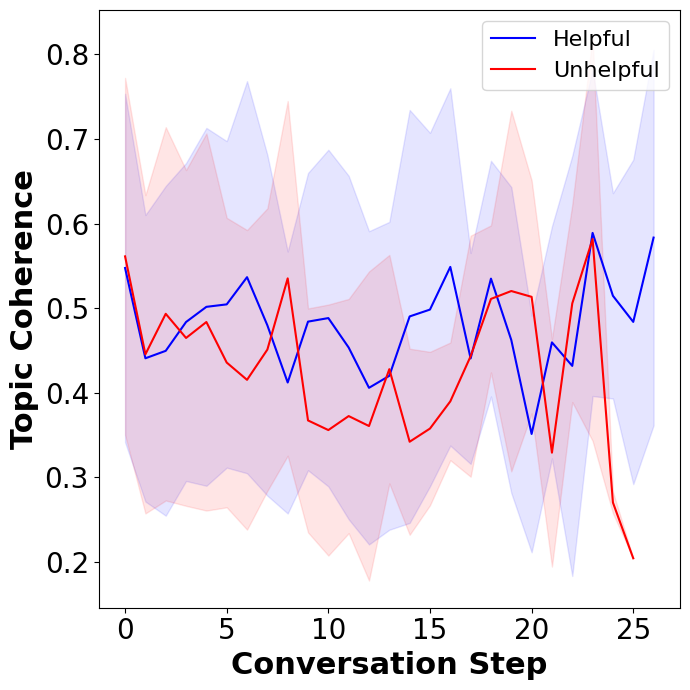

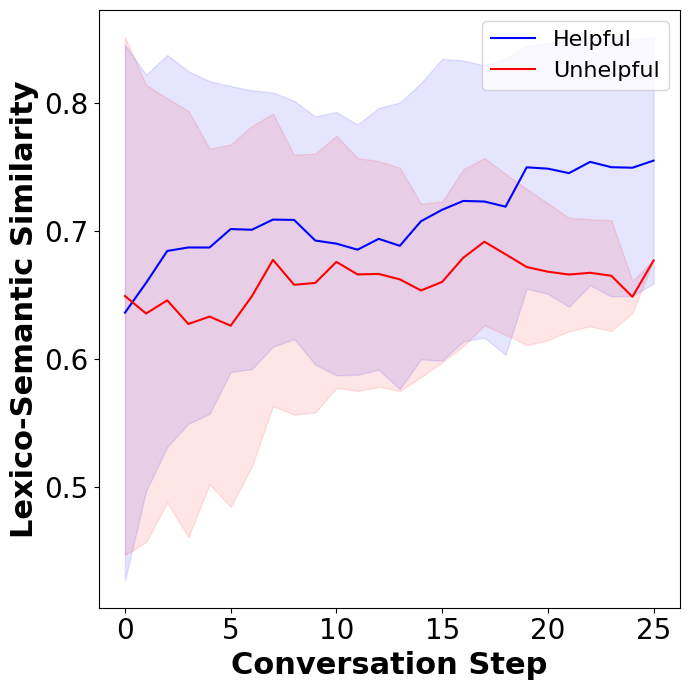

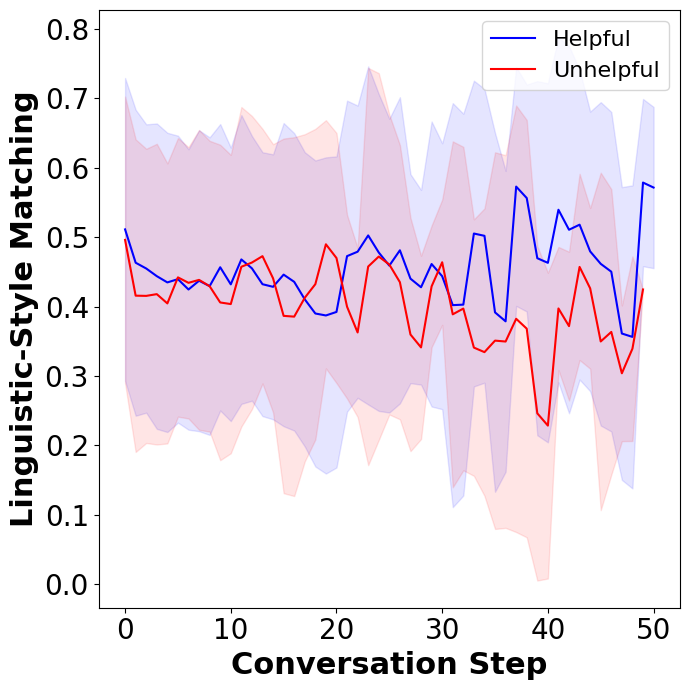

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate average progression and standard deviation for coherence
def calculate_average_progression1(coherence_progressions, n=0):
    max_length = max(len(scores['prompt+answer']) for scores in coherence_progressions) - n
    avg_prompts = np.zeros(max_length)
    std_prompts = np.zeros(max_length)
    
    for i in range(max_length):
        step_prompts = [scores['prompt+answer'][i] for scores in coherence_progressions if i < len(scores['prompt+answer'])]
        avg_prompts[i] = np.mean(step_prompts)
        std_prompts[i] = np.std(step_prompts)
    
    return avg_prompts, std_prompts

# Function to calculate average progression and standard deviation for LSM and similarity
def calculate_average_progression(lsm_progressions, n=0):
    max_length = max(len(similarity) for similarity in lsm_progressions)-n
    avg_similarity = np.zeros(max_length)
    std_similarity = np.zeros(max_length)
    
    for i in range(max_length):
        step_similarities = [similarity[i] for similarity in lsm_progressions if i < len(similarity)]
        avg_similarity[i] = np.mean(step_similarities)
        std_similarity[i] = np.std(step_similarities)
    
    return avg_similarity, std_similarity

# Calculate average and std for coherence
avg_prompts_help, std_prompts_help = calculate_average_progression1(coherence_progression_help_without_dup, 82)
avg_prompts_no_help, std_prompts_no_help = calculate_average_progression1(coherence_progression_no_help_without_dup, 15)

# Calculate average and std for cosine similarity
avg_similarity_help, std_similarity_help = calculate_average_progression(cumulative_similarity_help, 83)
avg_similarity_no_help, std_similarity_no_help = calculate_average_progression(cumulative_similarity_no_help, 15)

# Calculate average and std for LSM
avg_lsm_help, std_lsm_help = calculate_average_progression(cumulative_lsm_help, 166)
avg_lsm_no_help, std_lsm_no_help = calculate_average_progression(cumulative_lsm_no_help, 31)

# Plot and save Coherence progression
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(avg_prompts_help, label='Helpful', color='blue')
ax.fill_between(range(len(avg_prompts_help)), avg_prompts_help - std_prompts_help, avg_prompts_help + std_prompts_help, color='blue', alpha=0.1)
ax.plot(avg_prompts_no_help, label='Unhelpful', color='red')
ax.fill_between(range(len(avg_prompts_no_help)), avg_prompts_no_help - std_prompts_no_help, avg_prompts_no_help + std_prompts_no_help, color='red', alpha=0.1)
ax.set_xlabel('Conversation Step', fontsize=22, fontweight='bold')
ax.set_ylabel('Topic Coherence', fontsize=22, fontweight='bold')
ax.legend(fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.savefig('../coherence_progression.png', bbox_inches='tight', dpi=300)
# plt.show()

# Plot and save Cosine similarity progression
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(avg_similarity_help, label='Helpful', color='blue')
ax.fill_between(range(len(avg_similarity_help)), avg_similarity_help - std_similarity_help, avg_similarity_help + std_similarity_help, color='blue', alpha=0.1)
ax.plot(avg_similarity_no_help, label='Unhelpful', color='red')
ax.fill_between(range(len(avg_similarity_no_help)), avg_similarity_no_help - std_similarity_no_help, avg_similarity_no_help + std_similarity_no_help, color='red', alpha=0.1)
ax.set_xlabel('Conversation Step', fontsize=22, fontweight='bold')
ax.set_ylabel('Lexico-Semantic Similarity', fontsize=22, fontweight='bold')
ax.legend(fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.savefig('../cosine_similarity_progression.png', bbox_inches='tight', dpi=300)
# plt.show()

# Plot and save LSM progression
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(avg_lsm_help, label='Helpful', color='blue')
ax.fill_between(range(len(avg_lsm_help)), avg_lsm_help - std_lsm_help, avg_lsm_help + std_lsm_help, color='blue', alpha=0.1)
ax.plot(avg_lsm_no_help, label='Unhelpful', color='red')
ax.fill_between(range(len(avg_lsm_no_help)), avg_lsm_no_help - std_lsm_no_help, avg_lsm_no_help + std_lsm_no_help, color='red', alpha=0.1)
ax.set_xlabel('Conversation Step', fontsize=22, fontweight='bold')
ax.set_ylabel('Linguistic-Style Matching', fontsize=22, fontweight='bold')
ax.legend(fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.savefig('../lsm_progression.png', bbox_inches='tight', dpi=300)
# plt.show()


# RQ3

In [53]:
df_rq3 = pd.read_csv('../datasets/final_annotated_conversations1.csv')

In [54]:
len(df_rq3)

686

In [55]:
count_irrelevant = df_rq3['Deficiencies'].str.contains('Irrelevant').sum()
count_incorrect = df_rq3['Deficiencies'].str.contains('Incorrect').sum()
count_comp = df_rq3['Deficiencies'].str.contains('Not comprehensive').sum()
count_unresolved = df_rq3['Deficiencies'].str.contains('Not solved').sum()
count_unresolved += (df_rq3['Deficiencies'] == '-').sum()
count_hallucination = df_rq3['Deficiencies'].str.contains('Hallucination').sum()
count_unclear = df_rq3['Deficiencies'].str.contains('Unclear').sum()

count_not_helpful = df_rq3['Did ChatGPT help with the issue'].str.contains('No').sum()
count_helpful = df_rq3['Did ChatGPT help with the issue'].str.contains('Yes').sum()

print('Helpful: ' + str(count_helpful))
print('Not helpful: ' + str(count_not_helpful))
print('Irrelevant: ' + str(count_irrelevant))
print('Incorrect: ' + str(count_incorrect))
print('Not comprehensive: ' + str(count_comp))
print('Unclear: ' + str(count_unclear))
print('Hallucination: ' + str(count_hallucination))
print('Unresolved: ' + str(count_unresolved))


Helpful: 428
Not helpful: 258
Irrelevant: 19
Incorrect: 54
Not comprehensive: 39
Unclear: 14
Hallucination: 11
Unresolved: 121


In [56]:
from collections import defaultdict
import json

# Initialize the dictionary
task_issues_dict = defaultdict(lambda: defaultdict(int))

# Iterate through the DataFrame and update the dictionary
for _, row in df_rq3.iterrows():
    issue = row['Deficiencies']
    task1 = row['Type of issue/Problem (#1)']
    task2 = row['Type of issue/Problem (#2)']
    
    # Update the dictionary for both task columns
    if pd.notna(task1):
        if 'Irrelevant' in str(issue):
            task_issues_dict[task1]['Irrelevant'] += 1
        elif 'Incorrect' in str(issue):
            task_issues_dict[task1]['Incorrect'] += 1
        elif 'Not comprehensive' in str(issue):
            task_issues_dict[task1]['Not comprehensive'] += 1
        elif 'Unclear' in str(issue):
            task_issues_dict[task1]['Unclear'] += 1
        elif 'Hallucination' in str(issue):
            task_issues_dict[task1]['Hallucination'] += 1
        elif 'Not solved' in str(issue):
            task_issues_dict[task1]['Not solved'] += 1
        elif str(issue) == '-':
            task_issues_dict[task1]['Not solved'] += 1
    if pd.notna(task2) and not (task1 == 'tool/library/api recommendation' and task2 == 'tool/library/api recommendation'):
        if 'Irrelevant' in str(issue):
            task_issues_dict[task2]['Irrelevant'] += 1
        elif 'Incorrect' in str(issue):
            task_issues_dict[task2]['Incorrect'] += 1
        elif 'Not comprehensive' in str(issue):
            task_issues_dict[task2]['Not comprehensive'] += 1
        elif 'Unclear' in str(issue):
            task_issues_dict[task1]['Unclear'] += 1
        elif 'Hallucination' in str(issue):
            task_issues_dict[task2]['Hallucination'] += 1
        elif 'Not solved' in str(issue):
            task_issues_dict[task2]['Not solved'] += 1
        elif str(issue) == '-':
            task_issues_dict[task2]['Not solved'] += 1

print(json.dumps(task_issues_dict, indent=4))

{
    "code generation and implementation": {
        "Not solved": 47,
        "Incorrect": 12,
        "Not comprehensive": 7,
        "Irrelevant": 6,
        "Hallucination": 1
    },
    "tool/library/api recommendation": {
        "Irrelevant": 8,
        "Not solved": 29,
        "Incorrect": 23,
        "Hallucination": 5,
        "Not comprehensive": 8,
        "Unclear": 5
    },
    "debugging and code repair": {
        "Not solved": 19,
        "Incorrect": 13,
        "Irrelevant": 3,
        "Not comprehensive": 3,
        "Hallucination": 1,
        "Unclear": 1
    },
    "information retrieval": {
        "Not solved": 20,
        "Unclear": 5,
        "Hallucination": 4,
        "Not comprehensive": 15,
        "Irrelevant": 4
    },
    "system design and architecture": {
        "Not comprehensive": 1,
        "Not solved": 1
    },
    "code documentation/comment generation": {
        "Not solved": 1
    },
    "code explanation": {
        "Not solved": 5,
     

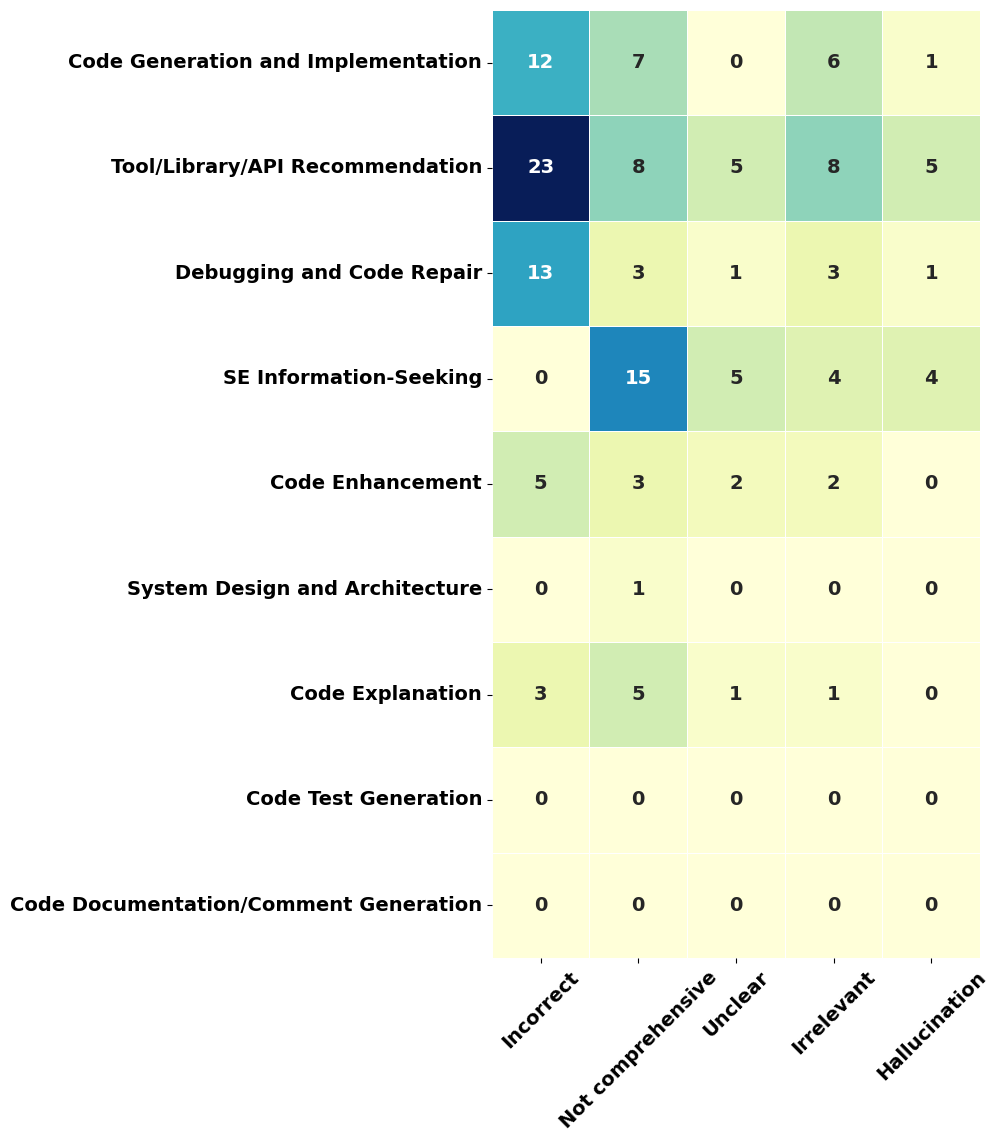

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Updated dataset with new categories
data = {
    "Code Generation and Implementation": {"Incorrect": 12, "Not comprehensive": 7, "Irrelevant": 6, "Hallucination": 1},
    "Tool/Library/API Recommendation": {"Incorrect": 23, "Not comprehensive": 8, "Unclear": 5, "Irrelevant": 8, "Hallucination": 5},
    "Debugging and Code Repair": {"Incorrect": 13, "Not comprehensive": 3, "Unclear": 1, "Irrelevant": 3, "Hallucination": 1},
    "SE Information-Seeking": {"Not comprehensive": 15, "Unclear": 5, "Irrelevant": 4, "Hallucination": 4},
    "Code Enhancement": {"Incorrect": 5, "Not comprehensive": 3, "Unclear": 2, "Irrelevant": 2},
    "System Design and Architecture": {"Not comprehensive": 1},
    "Code Explanation": {"Incorrect": 3, "Not comprehensive": 5, "Unclear": 1, "Irrelevant": 1},
    "Code Test Generation": {"Incorrect": 0, "Not comprehensive": 0, "Unclear": 0, "Irrelevant": 0},
    "Code Documentation/Comment Generation": {"Incorrect": 0, "Not comprehensive": 0, "Unclear": 0, "Irrelevant": 0},
}

# Convert data to DataFrame
df = pd.DataFrame(data).T
df = df[["Incorrect", "Not comprehensive", "Unclear", "Irrelevant", "Hallucination"]].fillna(0).astype(int)

# Create heatmap
plt.figure(figsize=(10, 12))
heatmap = sns.heatmap(df, annot=True, cmap="YlGnBu", fmt="d", cbar=False, linewidths=.5,
                      annot_kws={"size": 14, "fontweight": "bold"})

# Titles
plt.yticks(fontsize=14, weight='bold', rotation=0)

# plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xticks(fontsize=14, weight='bold', rotation=45)

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig("deficiencies_heatmap.png", dpi=300)
plt.show()
